# Movie Data Analysis
### Author: Dylan Beattie

### How best to break into the movie business
In the following analysis, we'll examine the broader trends in the film industry to help recommend to a beginning studio the best ways to maximize their film's chance for success. Should a studio focus on making standalone films or ones with franchise and sequel potential? Should the studio develop films with the domestic or foreign audience at the forefront of their mind? Which genres help guarantee film revenue? This questions will all be investigated in the forthcoming analysis.
 

We'll begin our analysis by importing the necessary libraries and initialzing our graphing environment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,8)})
#use following for printing plots for slide deck
sns.set(rc = {'figure.figsize':(11,6)})
TITLE_SIZE = 'x-large'
LABEL_SIZE = 'large'

### Investigating the draw of standalone movies vs sequels over time
The modern film industry seems dominated by sequels and franchises. Does the data support this, and if so, do sequel films actually generate more revenue?

To answer these questions, we'll begin by importing some data from [RottenTomatoes](https://www.rottentomatoes.com/), a film review aggregator site. RT data provides a sypnopsis for each film with basic box office gross data, along with a separate table of reviews for each film.

In [2]:
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", delimiter="\t")
rt_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", delimiter = "\t", encoding='unicode_escape')

Our data doesn't actually specify which movies are sequels or standalone films. To figure this out, we'll parse through the film synopsis' and reviews provided in the RT dataset for any mention of the words, *sequel*, *franchise*, *installment*, etc. This method won't provide 100% accuracy but will be suffient for showing the greater trends we're looking for.

In [3]:
%%capture
#don't display warnings about future regex deprecation

keywords = ['sequel', 'franchise', 'installment', 'prequel', 'series', 'spin-off']
pattern = '|'.join(keywords)

rt_reviews['is_sequel'] = rt_reviews['review'].str.contains(pattern)
sequels = rt_reviews[rt_reviews['is_sequel'] == True]
sequel_ids = set(sequels['id'])

rt_movie_info['reviews_suggest_sequel'] = rt_movie_info['id'].isin(sequel_ids)
rt_movie_info['synopsis_suggests_sequel'] = rt_movie_info['synopsis'].str.contains(pattern)
rt_movie_info['release_date'] = pd.DatetimeIndex(rt_movie_info['theater_date'])

rt_movie_info[rt_movie_info['reviews_suggest_sequel'] | rt_movie_info['synopsis_suggests_sequel']]
rt_movie_info['is_sequel'] = rt_movie_info['reviews_suggest_sequel'] | rt_movie_info['synopsis_suggests_sequel']
rt = rt_movie_info[rt_movie_info['box_office'].notna()]

rt['box_office'] = pd.to_numeric(rt['box_office'].str.replace(',', ''))
rt['year'] = pd.DatetimeIndex(rt['release_date']).year

Most of the films in the provided dataset were released in the mid-1990's or later so we'll filter out films made before the turn of the millenium. We'll then split the data by if it's a *standalone* or *sequel* and then plot the industry-wide box office gross for each over time.

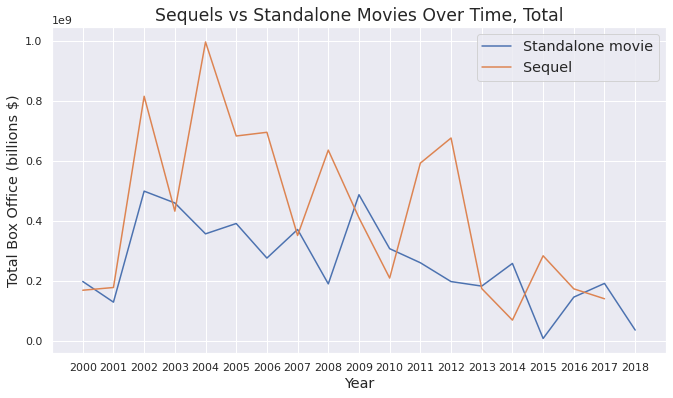

In [4]:
d = rt[rt['release_date'] >= '2000-01-01'].groupby(['year','is_sequel'])['box_office'].sum()
d.unstack().plot()
plt.xlabel("Year", fontsize = LABEL_SIZE)
plt.ylabel("Total Box Office (billions $)", fontsize = LABEL_SIZE)
plt.title("Sequels vs Standalone Movies Over Time, Total", fontsize = TITLE_SIZE)
plt.xticks(range(2000,2019))
plt.xlim(1999,2019)
plt.legend(['Standalone movie', 'Sequel'], fontsize= LABEL_SIZE)
plt.show()


Our intuition that the box office has been dominated by sequels is true. However, to further isolate the relationship between the two and weed out the effect of number of sequels produced per year, we'll next look at the average box office return for each category.

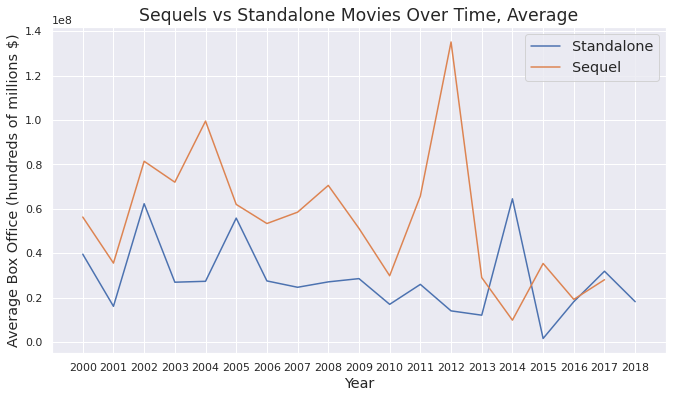

In [5]:
d = rt[rt['release_date'] >= '2000-01-01'].groupby(['year','is_sequel'])['box_office'].mean()
d.unstack().plot()
plt.xlabel("Year", fontsize = LABEL_SIZE)
plt.ylabel("Average Box Office (hundreds of millions $)", fontsize = LABEL_SIZE)
plt.title("Sequels vs Standalone Movies Over Time, Average", fontsize = TITLE_SIZE)
plt.xticks(range(2000,2019))
plt.xlim(1999,2019)
plt.legend(['Standalone', 'Sequel'], fontsize = LABEL_SIZE)
plt.show()


Apart from a brief recent blip, sequels/films in franchises are consistently more lucrative than standalone films. **Intentionally producing films with franchise potential is the best course of action for the burgeoning movie studio.**

#### Actionable insight: 
Microsoft should focus on making films with franchise potential by either: <ol> <li>1. Prioritize purchasing IP from other studios, similar to the strategy used by Disney over the last 15+ years (purchasing Marvel, Star Wars, etc.)</li> <li> 2. Make films tapping into the IP used in first-party XBox games (IP already owned by Microsoft).</li>![](shrek_2.png)

### Foreign Box Office is King: Visualizing the growth of movie sales outside the US

Next, we'll examine the the diminishing importance of the domestic box office and the rise of emerging economies to the studio's bottom line.

We'll use data from [the-numbers.com](https://www.the-numbers.com/), which provides detailed information about domestic and global box office revenue. First, let's clean up the data by casting strings to the appropriate data types and creating a new column *foreign_gross* which we will later analyze. 

In [6]:
%%capture
#Above line suppresses non-applicable FutureWarning about regex

tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
tn_movie_budgets['production_budget'] = pd.to_numeric(tn_movie_budgets['production_budget'].str.replace('$', '').str.replace(',', ''))
tn_movie_budgets['domestic_gross'] = pd.to_numeric(tn_movie_budgets['domestic_gross'].str.replace('$', '').str.replace(',', ''))
tn_movie_budgets['worldwide_gross'] = pd.to_numeric(tn_movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', ''))
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['foreign_gross'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['domestic_gross']



Next, we'll split the data by decade to examine the larger trends over time. We'll then calculate the average box office return for the average movie for each decade.

In [7]:
def filter_by_decade(df, decade_start_date, column_name = 'release_date'):
    year = 10
    decade_end_date = (str(int(decade_start_date[:4]) + year) + decade_start_date[4:])
    #print(decade_end_date)
    return df[(df[column_name] >= decade_start_date) & (df[column_name] < decade_end_date)]

decade_strings = ['1970-01-01', '1980-01-01', '1990-01-01', '2000-01-01', '2010-01-01']
movies_by_decade = list(map(lambda s: filter_by_decade(tn_movie_budgets, s), decade_strings))

decades_domestic_mean = list(map(lambda m: m['domestic_gross'].mean(), movies_by_decade))
decades_foreign_mean = list(map(lambda m: m['foreign_gross'].mean(), movies_by_decade))

dicts = {}
decade_labels = ['{}-{}'.format(d[:4], str(int(d[:4])+10)) for d in decade_strings]

for s, d_m, f_m in zip(decade_labels, decades_domestic_mean, decades_foreign_mean):
    dict_tmp = {'domestic_mean' : d_m, 
                'foreign_mean': f_m}
    dicts[s] = dict_tmp
    
df = pd.DataFrame(dicts)


Finally, we plot the results:

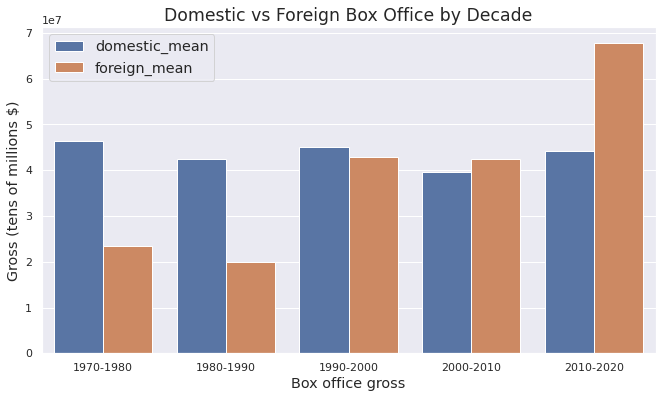

In [8]:
title = 'Domestic vs Foreign Box Office by Decade'
sns.barplot(x='Box office gross', y='value', hue='index',
            data=df.reset_index().melt(id_vars='index', var_name='Box office gross'))
# Show the plot
plt.title(title, fontsize = TITLE_SIZE)
plt.ylabel('Gross (tens of millions $)', fontsize = LABEL_SIZE)
plt.xlabel('Box office gross', fontsize = LABEL_SIZE)
plt.legend(fontsize= LABEL_SIZE)

plt.show()

When adjusted for inflation, domestic box office has remained mostly stagnant over the decades. Almost all box office growth has come from foreign sales. If we were to assume that this trend will to continue, the implication is clear: to maximize future movie profits, **studios will need to increasingly focus on making films with international appeal**.

But first, let's pause first to examine that assumption--*should we expect indefinite foreign box office growth?* We'll examine some economic forecasts to investigate this further.

Let's download the [OECD's projections](https://data.oecd.org/gdp/gdp-long-term-forecast.htm) of long-term GDP growth and isolate it to country-specific projections.

In [9]:
#data from https://data.oecd.org/gdp/gdp-long-term-forecast.htm
forecast = pd.read_csv('economic_forecast.csv')
#Isolate countries, i.e. Drop values of non-country codes
non_countries = ['WLD', 'G20', 'OECD', 'G7M', 'EA17']
forecast = forecast[~forecast['LOCATION'].isin(non_countries)]
forecast.sort_values(by=['TIME', 'Value'], ascending = False).head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
1451,CHN,GDPLTFORECAST,TOT,MLN_USD,A,2060,62139790.0,NaN
1539,IND,GDPLTFORECAST,TOT,MLN_USD,A,2060,42203870.0,NaN
1319,USA,GDPLTFORECAST,TOT,MLN_USD,A,2060,36527240.0,NaN
1583,IDN,GDPLTFORECAST,TOT,MLN_USD,A,2060,12319850.0,NaN
1231,TUR,GDPLTFORECAST,TOT,MLN_USD,A,2060,7067842.0,NaN



This data measures GDP in total million US dollars. We'll make it more comprehensible by converting the value into trillions of dollars. Let's examine the top eight projected economies in 2060.


In [10]:
forecast['Value'] = forecast['Value'] / 10**6

number_of_top_countries = 8
top_countries_by_gdp = forecast.sort_values(by=['TIME', 'Value']
                                            , ascending = False)['LOCATION'][:number_of_top_countries]

print(top_countries_by_gdp)

1451    CHN
1539    IND
1319    USA
1583    IDN
1231    TUR
659     JPN
395     DEU
1363    BRA
Name: LOCATION, dtype: object


Now we have the top projected economies in 2060. For graph legibility we'll create a set of labels with the full country name. We'll then create a dictionary for each of these countries containing their GDP in 2020 and projected GDP in 2060.

In [11]:
countries_full_name = ['China', 'India', 'USA', 'Indonesia', 'Turkey', 'Japan', 'Germany', 'Brazil']

dicts = {}
years_to_compare = [2020, 2060]

for country, full_name in zip(top_countries_by_gdp[::-1], countries_full_name[::-1]):
    #note here: if .item() isn't included, value is a series and not a float
    y1_val = forecast[(forecast['LOCATION'] == country) & (forecast['TIME'] == years_to_compare[0])]['Value'].item()
    y2_val = forecast[(forecast['LOCATION'] == country) & (forecast['TIME'] == years_to_compare[1])]['Value'].item()
    dict_tmp = {str(years_to_compare[0]) : y1_val,
                str(years_to_compare[1]) : y2_val}
    dicts[full_name] = dict_tmp

df_eco_forecast = pd.DataFrame(dicts)

Next we plot:

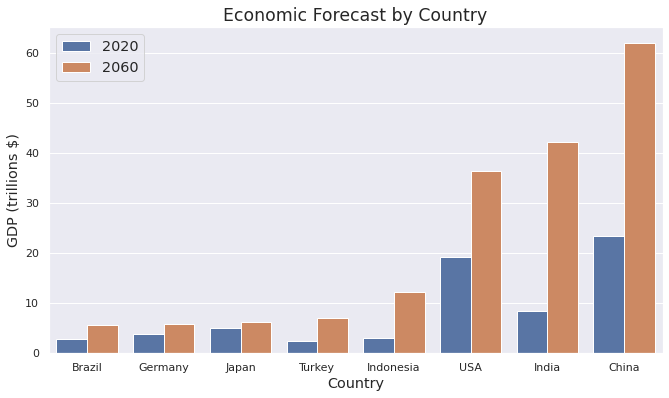

In [12]:
title = 'Economic Forecast by Country'

fig = sns.barplot(x='Country', y='value', hue='index', 
            data=df_eco_forecast.reset_index().melt(id_vars='index', var_name='Country')).\
            set_title(title)

plt.title(title, fontsize = TITLE_SIZE)
plt.ylabel('GDP (trillions $)', fontsize = LABEL_SIZE)
plt.xlabel('Country', fontsize = LABEL_SIZE)
plt.legend(fontsize = LABEL_SIZE)
# Show the plot
plt.show()

It's clear: growth in the US economy is predicted to be vastly outpaced in the upcoming decades. We'll investigate this one step further by examining the US economy and it's projected growth in relation to the other largest global economies.

In [13]:
for_top_five = forecast[forecast['LOCATION'].isin(top_countries_by_gdp[0:5])]

usa_gdp_2020 = for_top_five[(for_top_five['TIME'] == 2020) & (for_top_five['LOCATION'] == 'USA')]['Value'].item()
usa_gdp_2060 = for_top_five[(for_top_five['TIME'] == 2060) & (for_top_five['LOCATION'] == 'USA')]['Value'].item()

global_gdp_2020 = for_top_five[(for_top_five['TIME'] == 2020) & (for_top_five['LOCATION'] != 'USA')]['Value'].sum()
global_gdp_2060 = for_top_five[(for_top_five['TIME'] == 2060) & (for_top_five['LOCATION'] != 'USA')]['Value'].sum()

gdp_2020 = [usa_gdp_2020, global_gdp_2020]
gdp_2060 = [usa_gdp_2060, global_gdp_2060]


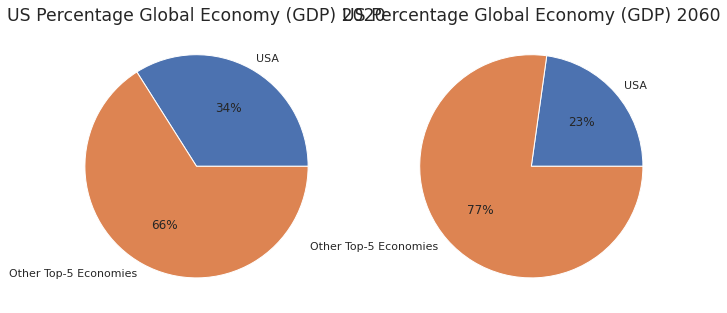

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
labels = ['USA', 'Other Top-5 Economies']
ax1.pie(gdp_2020, autopct='%.0f%%', labels = labels)
ax1.set_title('US Percentage Global Economy (GDP) 2020', fontsize = TITLE_SIZE)
ax2.pie(gdp_2060, autopct='%.0f%%', labels = labels)
ax2.set_title('US Percentage Global Economy (GDP) 2060', fontsize = TITLE_SIZE)

plt.show()

Pie charts aren't always useful, but these further cement the trend shown earlier: emerging economies are greatly outpacing the US in economic growth.

To get back to our original point: domestic box office sales have mostly flattened. **Movie sales growth is almost entirely dependent on the growth of the foreign box office**. Economic forecasting suggests this trend will continue indefinitely as growth in emerging economies greatly outpaces the US as a whole.

#### Actionable insight:
To maximize future profits, Microsoft must focus on producing films that primarily focus on the interests of international audiences. This leads to our final question.


### Which genres generate the highest box office internationally?

We'll start by importing data from [themoviedb.org](https://www.themoviedb.org/) which conveniently provides genre information for each movie. We'll only be examining the relationship between genre and foreign box revenue, so we'll treat every instance of a reported genre by itself (that is, movies with multiple genres will have each genre analyzed separetely).

In [15]:
from ast import literal_eval

tmdb = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])

#Found on https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
tmdb_genres_string = """
    Action,          28
    Adventure,       12
    Animation,       16
    Comedy,          35
    Crime,           80
    Documentary,     99
    Drama,           18
    Family,          10751
    Fantasy,         14
    History,         36
    Horror,          27
    Music,           10402
    Mystery,         9648
    Romance,         10749
    Science Fiction, 878
    TV Movie,        10770
    Thriller,        53
    War,             10752
    Western,         37
""".strip()

genre_codes = pd.DataFrame([x.split(',') for x in tmdb_genres_string.split('\n')], columns=['genre', 'code'])
genre_codes = dict(zip(pd.to_numeric(genre_codes.code), genre_codes.genre))
movies_by_genre = pd.merge(tmdb, tn_movie_budgets, left_on=['title', 'release_date'], right_on = ['movie', 'release_date'])
#explode() method won't work without following line of code
movies_by_genre['genre_ids'] = movies_by_genre['genre_ids'].apply(literal_eval)
movies_by_genre = movies_by_genre.explode('genre_ids')
movies_by_genre['genre'] = movies_by_genre['genre_ids'].map(genre_codes)

We'll then filter the data by genre to find how well each correlates to foreign box office revenue and plot the results.

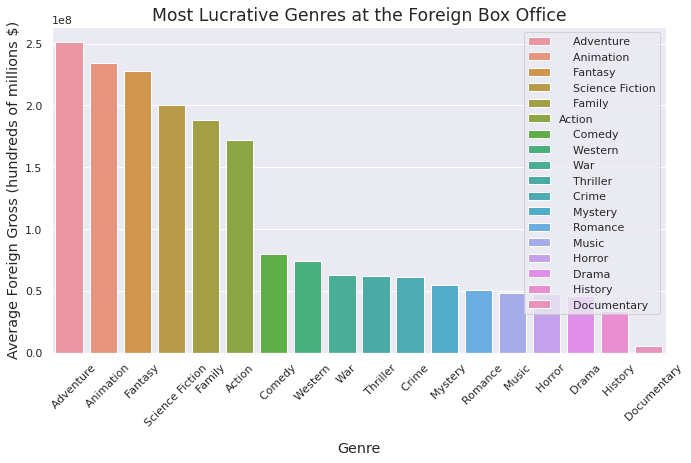

In [16]:
df_genre = movies_by_genre.groupby(['genre']).agg(mean_foreign_gross = ('foreign_gross', 'mean')).\
                                            sort_values(by='mean_foreign_gross', ascending = False)
df_genre = df_genre.reset_index()
sns.barplot(data = df_genre, x = 'genre', y = 'mean_foreign_gross', hue='genre', dodge = False)
plt.xticks(rotation = 45)
plt.xlabel('Genre', fontsize = LABEL_SIZE)
plt.ylabel('Average Foreign Gross (hundreds of millions $)', fontsize = LABEL_SIZE)
plt.legend(loc = "upper right")
plt.title('Most Lucrative Genres at the Foreign Box Office', fontsize = TITLE_SIZE)

plt.show()

The disparity between genre in relation to foreign box office is stark. Six genres: *Adventure*, *Animation*, *Fantasy*, *Science Fiction*, *Family*, and *Action* draw on average 2-3x the revenue internationally as the most unpopular genres.

Perhaps unsuprisingly, the *Documentary* genre is by far the least lucrative genre internationally. It is with much sadness that I cannot professionally suggest that Microsoft hire Ken Burns to continue his masterpiece miniseries *Baseball* with it's much anticipated *11th Inning*.

![](baseball_ken_burns.jpeg)

#### Actionable Insight:
Genre matters when it comes to foreign box office success and choosing popular genres when greenlighting movie scripts is low-hanging fruit for any movie studio. Movies intended for families, both animated and live-action, with action and fantasy/sci-fi elements consistently do well internationally.

# Conclusion

To summarize, a young movie studio should focus on three things to maximize their films success: <ol><li>1. **Greenlight films that have the potential to be turned into franchises.** The quickest way to do this is to use pre-existing IP, either via acquisition or using in-house IP (IP owned by Microsoft for the use in XBOX first-party development).</li><li>2. **Focus on making films for internationally audiences first, domestic audiences second.** Domestic box office has remained mostly stagnant (even regressing slightly) in the previous decades. Foreign box office, however, has seen continuous growth and economic forecasting suggests this trend will continue in the indefinite future.</li><li>3. **Make family films with action, fantasy, and sci-fi elements.** These genres consistently outdraw other genres internationally, and as previously stated, foreign box office should be the fitness function Microsoft optimizes its movies for.</li></ol>Following these three principles will help ensure the studio's success and longevity in the film industry.